# World Ocean Atlas Dataset

This notebooks accesses the [World Ocean Atlas](https://www.ncei.noaa.gov/products/world-ocean-atlas) dataset using [intake](https://intake.readthedocs.io) and generates a merged dataset for use in the calculation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import data_collections as dc
import intake
import matplotlib.pyplot as plt
import thermodyn
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Load World Ocean Atlas data

Access `intake` catalog for remote data.

In [3]:
catalog = intake.open_catalog(f'data/catalogs/woa2018-catalog.yml')
catalog

woa2018-catalog:
  args:
    path: data/catalogs/woa2018-catalog.yml
  description: World Ocean Atlas, v2018
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


Compile data comprising a monthly climatology

In [4]:
ds_list = []

variables = dict(
    oxygen=dict(keep_vars=["o_an", "depth_bnds"], set_coords=["depth_bnds"]),
    temperature=dict(keep_vars=["t_an"]),
    salinity=dict(keep_vars=["s_an"]),
)


ds_list = []
for variable, info in variables.items():
    ds_list_inner = []
    for month in range(1, 13):
        dsi = (
            catalog[variable](time_code=month)
            .to_dask()[info["keep_vars"]]
            .isel(time=0, drop=True)
            .sel(depth=slice(0, 1000.0))
        )
        if 'set_coords' in info:
            dsi = dsi.set_coords(info['set_coords'])

        ds_list_inner.append(dsi)

    ds_list.append(xr.concat(ds_list_inner, dim="time", coords="minimal", combine_attrs="override"))

ds = xr.merge(ds_list).rename({"o_an": "O2", "t_an": "TEMP", "s_an": "SALT"})

ds["pO2"] = thermodyn.compute_pO2(
    O2=ds.O2,
    T=ds.TEMP,
    S=ds.SALT,
    depth=xr.full_like(ds.TEMP, fill_value=1.0) * ds.depth,
    gravimetric_units=True,
)

# add "dz" variable
ds["dz"] = ds.depth_bnds.diff("nbounds").squeeze()
ds.dz.attrs['units'] = ds.depth.attrs['units']

# add gridcell "area" variable
ds["area"] = util.compute_grid_area(ds)

# add "volume" variable
isvalid = (ds.TEMP.notnull() & ds.O2.notnull() & ds.SALT.notnull()).all('time')
ds["volume"] = (ds.dz * ds.area).where(isvalid)
ds.volume.attrs["long_name"] = "Volume"
ds.volume.attrs["units"] = "m^3"

# set some attributes
ds.lat.attrs["long_name"] = "Latitude"
ds.lat.attrs["units"] = "degrees_north"

ds.lon.attrs["long_name"] = "Longitude"
ds.lon.attrs["units"] = "degrees_east"

ds

<xarray.Dataset>
Dimensions:     (time: 12, depth: 47, lat: 180, lon: 360, nbounds: 2)
Coordinates:
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 ... 975.0 975.0 1.025e+03
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth       (depth) float32 0.0 5.0 10.0 15.0 ... 850.0 900.0 950.0 1e+03
Dimensions without coordinates: time, nbounds
Data variables:
    O2          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 47, 180, 360), meta=np.ndarray>
    TEMP        (time, depth, lat, lon) float32 dask.array<chunksize=(1, 47, 180, 360), meta=np.ndarray>
    SALT        (time, depth, lat, lon) float32 dask.array<chunksize=(1, 47, 180, 360), meta=np.ndarray>
    pO2         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 47, 180, 360), meta=np.ndarray>
    dz          (depth) float32 2.5 5.0 5.0 5.0 5.0 ... 50.0 50.0 50.0 50.0 50.0
    area        (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    volume      (depth, lat, lon) float64 dask.array<chunksize=(47, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : mole_concentrat...
    summary:                         Climatological mean dissolved oxygen for...
    references:                      Garcia, H. E., K. Weathers, C. R. Paver,...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

## Peek and verify data

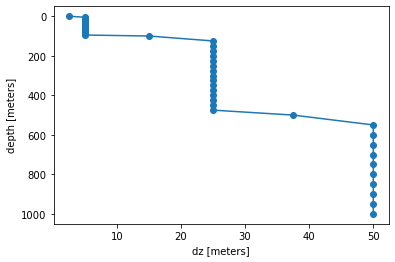

In [5]:
ds.dz.plot(y='depth', yincrease=False, marker='o');

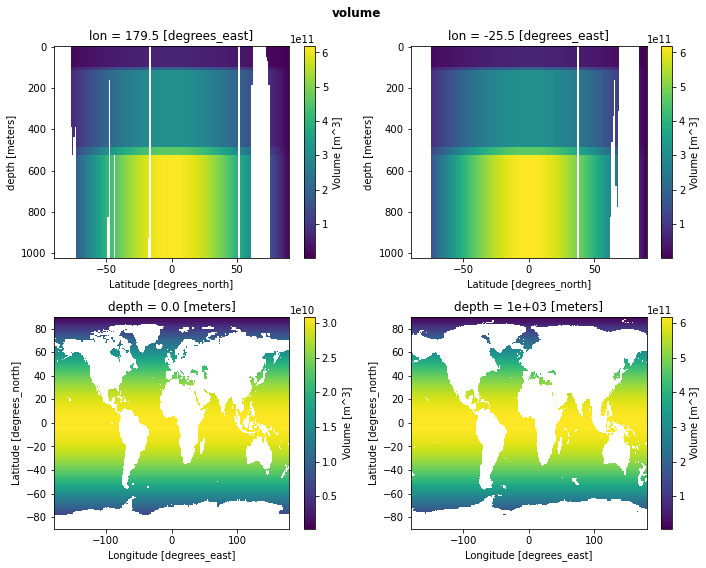

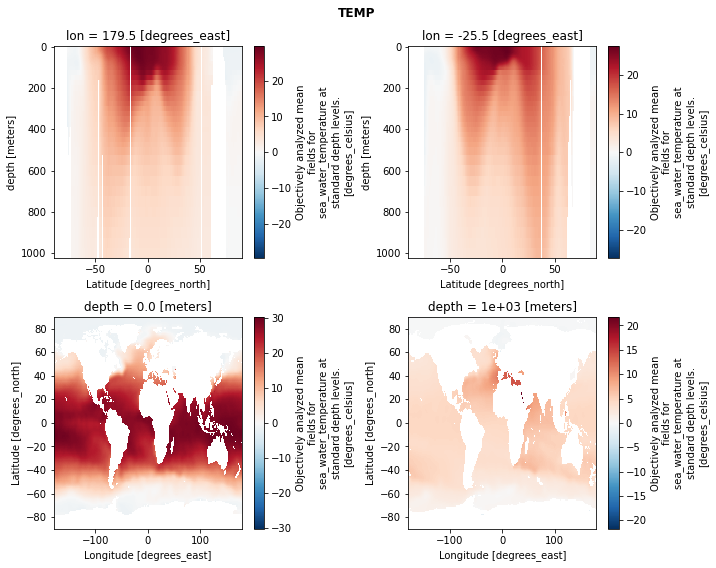

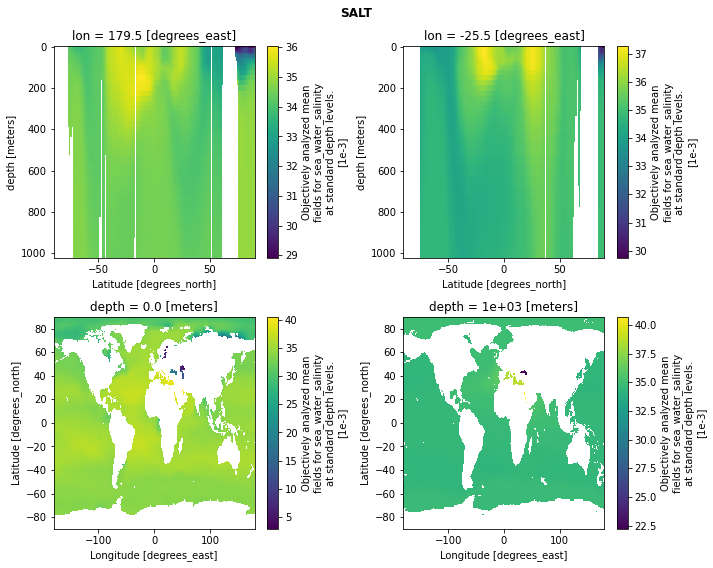

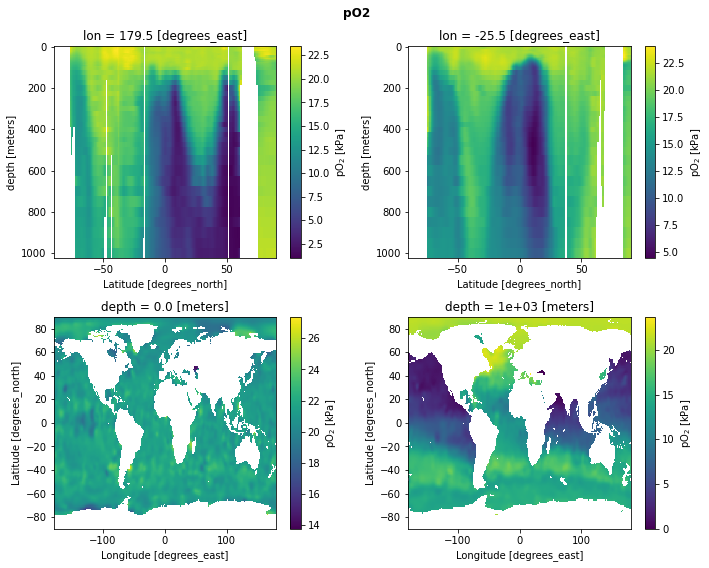

In [6]:
for field in ['volume', 'TEMP', 'SALT', 'pO2']:
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    selkw = {'time': 0} if 'time' in ds[field].dims else {}

    ds[field].sel(lon=179.5, **selkw).plot(yincrease=False, ax=axs[0, 0])
    ds[field].sel(lon=-25.5, **selkw).plot(yincrease=False, ax=axs[0, 1])

    ds[field].sel(depth=0.0, **selkw).plot(ax=axs[1, 0])
    ds[field].sel(depth=1000.0, **selkw).plot(ax=axs[1, 1])
    plt.suptitle(field, fontweight='bold')
    plt.tight_layout();

## Write cache file to project catalog

In [7]:
this_notebook = 'obs-woa2018.ipynb'

curator = util.curator_local_assets()

key = 'woa2018'

cache_file = f'{dc.cache_dir}/{key}.zarr'
os.makedirs(os.path.dirname(cache_file), exist_ok=True)

with util.timer(f"write: {cache_file}"):
    ds.to_zarr(cache_file, mode='w', consolidated=True)

curator.add_source(
    key=key,
    urlpath=cache_file,
    description=f'World Ocean Atlas, 2018 data; processed by {this_notebook}',
    driver='zarr',
    overwrite=True,
)

ds.info()

[write: /glade/scratch/mclong/ocean-metabolism/woa2018.zarr]: 8.85237s
overwriting "woa2018" key in "sources"
xarray.Dataset {
dimensions:
	time = 12 ;
	depth = 47 ;
	lat = 180 ;
	lon = 360 ;
	nbounds = 2 ;

variables:
	float32 O2(time, depth, lat, lon) ;
		O2:standard_name = mole_concentration_of_dissolved_molecular_oxygen_in_sea_water ;
		O2:long_name = Objectively analyzed mean fields for mole_concentration_of_dissolved_molecular_oxygen_in_sea_water at standard depth levels. ;
		O2:cell_methods = area: mean depth: mean time: mean within years time: mean over years ;
		O2:grid_mapping = crs ;
		O2:units = micromoles_per_kilogram ;
	float32 depth_bnds(depth, nbounds) ;
		depth_bnds:comment = depth bounds ;
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = Latitude ;
		lat:units = degrees_north ;
		lat:axis = Y ;
		lat:bounds = lat_bnds ;
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = Longitude ;
		lon:units = degrees_east ;
		lon:axis = X 